In [21]:
pip install -q -U "tensorflow-text==2.8.*"

Note: you may need to restart the kernel to use updated packages.


In [22]:
pip install -q tf-models-official==2.7.0

Note: you may need to restart the kernel to use updated packages.


In [23]:
import os
import shutil

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [24]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = tf.squeeze(tf.constant([dataframe.pop('label')]), axis=0)
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels)).batch(
        batch_size)
  return ds

In [25]:
ds = pd.read_csv('main.csv')
ds.head()


,title,author,text,label
0,House Dem Aide: We Didn't Even See Comey's Let...,Darrell Lucus,House Dem Aide: We Didn't Even See Comey's Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \r\nAn Iranian woman has been sentenced ...,1


In [28]:
ds['text'] = ds['title'] + ' ' + ds['text']
#ds.pop('id')
ds.pop('title')
ds.pop('author')
ds.head()

,text,label
0,House Dem Aide: We Didn't Even See Comey's Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",0
2,Why the Truth Might Get You Fired Why the Trut...,1
3,15 Civilians Killed In Single US Airstrike Hav...,1
4,Iranian woman jailed for fictional unpublished...,1


In [29]:
ds = ds.dropna()

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
train_ds, test_ds = train_test_split(ds, test_size=0.2)

In [32]:
test_ds, val_ds = train_test_split(test_ds, test_size=0.2)

In [33]:
train_ds = df_to_dataset(train_ds, 32)
test_ds = df_to_dataset(test_ds, 32)
val_ds = df_to_dataset(val_ds, 32)


In [34]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [35]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [36]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [37]:
classifier_model = build_classifier_model()

In [38]:
tf.keras.utils.plot_model(classifier_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [39]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [40]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [41]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [42]:
history = classifier_model.fit(x=train_ds,
                               validation_data=test_ds,
                               epochs=epochs)

Epoch 1/5
452/452 [==============================] - 1735s 4s/step - loss: 0.1390 - binary_accuracy: 0.9259 - val_loss: 0.0107 - val_binary_accuracy: 0.9972
Epoch 2/5
452/452 [==============================] - 1708s 4s/step - loss: 0.0111 - binary_accuracy: 0.9974 - val_loss: 0.0095 - val_binary_accuracy: 0.9979
Epoch 3/5
452/452 [==============================] - 1826s 4s/step - loss: 0.0052 - binary_accuracy: 0.9987 - val_loss: 0.0090 - val_binary_accuracy: 0.9983
Epoch 4/5
452/452 [==============================] - 1953s 4s/step - loss: 0.0016 - binary_accuracy: 0.9994 - val_loss: 0.0077 - val_binary_accuracy: 0.9979
Epoch 5/5
452/452 [==============================] - 1997s 4s/step - loss: 3.9541e-04 - binary_accuracy: 0.9999 - val_loss: 0.0071 - val_binary_accuracy: 0.9976


In [43]:
loss, accuracy = classifier_model.evaluate(val_ds)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')


23/23 [==============================] - 27s 1s/step - loss: 0.0083 - binary_accuracy: 0.9986
Loss: 0.008349742740392685
Accuracy: 0.9986149668693542


In [44]:
validate = pd.read_csv('news_mergeAll.csv')
validate['text'] = validate['title'] + ' ' + validate['text']
validate.pop('title')
validate.pop('author')

0                        Amelia Teng
1                      Chin Soo Fang
2                        Timothy Goh
3                         Prisca Ang
4                        Timothy Goh
                    ...             
2440          Ahmad Zhaki Abdullah  
2441                    Ian Cheng   
2442                  Lakeisha Leo  
2443                  Chew Hui Min  
2444                   Vanessa Lim  
Name: author, Length: 2445, dtype: object

In [45]:
validate_sigma = validate
validate = df_to_dataset(validate, 32)

In [46]:
validate = validate.prefetch(buffer_size=AUTOTUNE)

In [47]:
vloss, vaccuracy = classifier_model.evaluate(validate)
print(f'Loss: {vloss}')
print(f'Accuracy: {vaccuracy}')

77/77 [==============================] - 95s 1s/step - loss: 0.1283 - binary_accuracy: 0.9616
Loss: 0.12834548950195312
Accuracy: 0.9615541696548462


In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from matplotlib import pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pylab as pl

# predict and label whether real or fake 
pred= classifier_model.predict(validate)
# pl.matshow(cm)
# pl.title('Confusion matrix of the classifier')
# pl.colorbar()
# pl.show()















2362


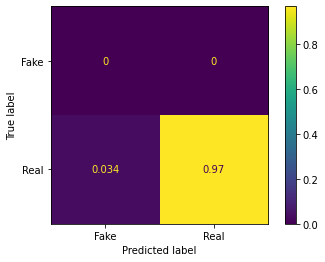

In [50]:
number_of_predictions = len(pred)
prediction_list = []
for i in range(number_of_predictions):
    # Note here we will label those 0 or below as fake news. Otherwise, they are labelled as real news 
    if pred[i][0] <= 0: #fake 
        prediction_list.append(0)
    else:
        prediction_list.append(1)

print(prediction_list.count(1)) #1881, about 76% predicted as real, in reality, all input instances in validation are real (1)

label_list = [1] * 2445

cm = confusion_matrix(label_list,prediction_list, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['Fake','Real'])

from matplotlib import pyplot as plt
cmd.plot()

# pl.matshow(cm)
# pl.title("Confusion matrix of classifier on validation set")
# pl.colorbar()
# pl.show()





In [52]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
#actual_label,prediction_list_version_2
print(f"The precision score is:{precision_score(label_list,prediction_list)}.")
print(f"The accuracy score is:{accuracy_score(label_list,prediction_list)}.")
print(f"The recall score is:{recall_score(label_list,prediction_list)}.")
print(f"The f1 score is:{f1_score(label_list,prediction_list)}.")


The precision score is:1.0.
The accuracy score is:0.9660531697341513.
The recall score is:0.9660531697341513.
The f1 score is:0.9827335136259622.


In [53]:
# Here we will be investigating the confusion matrix of our train.csv 
# So as to have a dataset with a mixture of target concept - 0 and 1 
# 0 as fake news, 1 as real news 
train_ds_investigate, test_ds_investigate = train_test_split(ds, test_size=0.2)

actual_label = list(test_ds_investigate.label)

predicted_preliminary = classifier_model.predict(test_ds_investigate['text'])




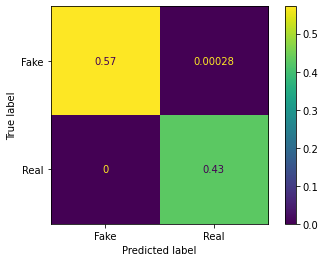

In [54]:
number_of_predictions_version_2 = len(predicted_preliminary) #3655 
 
prediction_list_version_2 = []
for i in range(number_of_predictions_version_2):
    # Note here we will label those 0 or below as fake news. Otherwise, they are labelled as real news 
    if predicted_preliminary[i][0] <= 0: #fake 
        prediction_list_version_2.append(0)
    else:
        prediction_list_version_2.append(1)

#print(prediction_list.count(1)) #1881, about 76% predicted as real, in reality, all input instances in validation are real (1)

cm = confusion_matrix(actual_label,prediction_list_version_2, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['Fake','Real'])
cmd.plot()
# pl.matshow(cm)
# pl.title("Confusion matrix of classifier on validation set")
# pl.colorbar()
# pl.show()


In [55]:
#actual_label,prediction_list_version_2
print(f"The precision score is:{precision_score(actual_label,prediction_list_version_2)}.")
print(f"The accuracy score is:{accuracy_score(actual_label,prediction_list_version_2)}.")
print(f"The recall score is:{recall_score(actual_label,prediction_list_version_2)}.")
print(f"The f1 score is:{f1_score(actual_label,prediction_list_version_2)}.")

### End of appended code chunks 


The precision score is:0.999353169469599.
The accuracy score is:0.9997229916897507.
The recall score is:1.0.
The f1 score is:0.9996764801035264.


In [56]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<5} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()

In [57]:
data = pd.read_csv('news_mergeAll.csv')
data['text'] = data['title'] + ' ' + data['text']
data.pop('title')
data.pop('author')
data.head()

,text,label
0,MPs including those from Workers' Part...,1
1,"MPs discuss flexiwork implementation, ...",1
2,"Over 8,800 cases of Covid-19 reinfecti...",1
3,MAS receives over 580 applications for...,1
4,Singapore has discussed 'very painful'...,1


In [58]:
examples = data['text']

In [59]:
results = tf.sigmoid(classifier_model(tf.constant(data['text'])))

In [62]:
# Now we want to sieve out relevant datas 
# Code chunks below are meant for EDA for our Team report under the Discussion/Additonal Remarks section! 
test_ds_investigate
lol = pd.DataFrame({'predicted': prediction_list_version_2})

C = test_ds_investigate.reset_index(drop=True).join(lol)
C.to_csv('test_ds_explorer.csv') 




In [63]:
# We now proceed to sieve out the validation set (Basically the local news ones where all are presumed to be True - 1)
validate_sigma
wtf = pd.DataFrame({'predicted': prediction_list})


D = validate_sigma.reset_index(drop=True).join(wtf)
D.to_csv('validation_ds_explorer.csv')
D

,text,label,predicted
0,MPs including those from Workers' Part...,1,1
1,"MPs discuss flexiwork implementation, ...",1,1
2,"Over 8,800 cases of Covid-19 reinfecti...",1,1
3,MAS receives over 580 applications for...,1,1
4,Singapore has discussed 'very painful'...,1,1
...,...,...,...
2440,CNB launches new children's book about s...,1,1
2441,Singaporeans strongly advised against tr...,1,1
2442,Singapore's manufacturing output expands...,1,1
2443,Some pre-schools to screen kids for deve...,1,1
